Here is the oryginal implementation: https://github.com/MHersche/eegnet-based-embedded-bci

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mne
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
from torch import nn
from dataloader import CreateIDs, DataSet
from model import EEGNet_lowpower
from training_loop import TrainingLoop
from torch.utils.data import DataLoader

sns.set_style('whitegrid')

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
DOWNSAMPLING_FACTOR = 2
NUMBER_OF_CHANNELS = 64
N_SAMPLES_PER_RECORDING = 5
TASK_MODE = 'all_tasks'

## Dataset description

https://mne.tools/stable/generated/mne.datasets.eegbci.load_data.html

* 109 participant from whom 105 have complete set of recordings
* for each participant there are 14 recordings - trials
* Division of trials for each participant:
    * two baseline trials - one with open eyes and one with closed eyes - without any tasks
    * three trials per each of the four tasks (left/right and top/bottom)
</br></br>
* Overall description of procedure:
    1. Opening or closing left or right fist after the target appearing on left or right side of the screen until the target dissapears
    2. Opening or closing either both firsts or both feet depending if target appears on the top or the bottom of the screean
</br></br>
* Tasks:
    1. open and lose left or right first
    2. imagine opening or closing left or right first
    3. Open and close both fists or both feet
    4. Imagine opening or closing both fists of both feet
</br></br>
* Experimental run:
    1. Open eye baseline
    2. Closed eye baseline
    3. Task 1
    4. Task 2
    5. Task 3
    6. Task 4
    7. Task 1
    8. Task 2
    9. Task 3
    10. Task 4
    11. Task 1
    12. Task 2
    13. Task 3
    14. Task 4

* Annotations:
    1. T0 - rest
    2. T1 - onset of motion (real or imagined) of the left fist:
        * Left fist runs: 3,4,7,8,11,12
        * Both fists: 5,6,9,10,13,14
    3. T2 - onset of motion (real or imagined) of the right feet or both feet
        * Right fist runs: 3,4,7,8,11,12
        * Both feet: 5,6,9,10,13,14


# Data exploration

In [4]:
first_participant_folder = '/Users/ivojohn/BCI/Models/Motor imaginery fists right:left/Dataset/files/S001'
first_recording_path = 'S001R12.edf'

first_recording = mne.io.read_raw_edf(os.path.join(first_participant_folder, first_recording_path))
first_recording

Extracting EDF parameters from /Users/ivojohn/BCI/Models/Motor imaginery fists right:left/Dataset/files/S001/S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<RawEDF | S001R12.edf, 64 x 20000 (125.0 s), ~64 kB, data not loaded>

In [5]:
first_recording_df = first_recording.to_data_frame()
first_recording_df.head()

,time,Fc5.,Fc3.,Fc1.,Fcz.,Fc2.,Fc4.,Fc6.,C5..,C3..,...,P8..,Po7.,Po3.,Poz.,Po4.,Po8.,O1..,Oz..,O2..,Iz..
0,0.00000,-17.0,-30.0,-37.0,-57.0,-67.0,-84.0,-57.0,-6.0,-32.0,...,-11.0,-16.0,-15.0,-6.0,-10.0,18.0,-22.0,-4.0,-77.0,-51.0
1,0.00625,-5.0,-14.0,-22.0,-40.0,-48.0,-68.0,-52.0,7.0,-21.0,...,-5.0,-7.0,-7.0,-4.0,-11.0,19.0,-25.0,-13.0,-81.0,-58.0
2,0.01250,-3.0,-10.0,-9.0,-24.0,-26.0,-52.0,-36.0,10.0,-19.0,...,-14.0,-5.0,-8.0,-6.0,-18.0,14.0,-19.0,-10.0,-82.0,-56.0
3,0.01875,2.0,-8.0,-1.0,-5.0,-8.0,-35.0,-24.0,16.0,-13.0,...,19.0,20.0,16.0,26.0,20.0,56.0,0.0,12.0,-59.0,-32.0
4,0.02500,12.0,-3.0,4.0,15.0,12.0,-14.0,-5.0,21.0,-11.0,...,31.0,33.0,25.0,27.0,27.0,65.0,24.0,38.0,-31.0,3.0


Number of time points in recording:  20000


Text(0.5, 1.0, 'Channel Fc5. - first 1000 points')

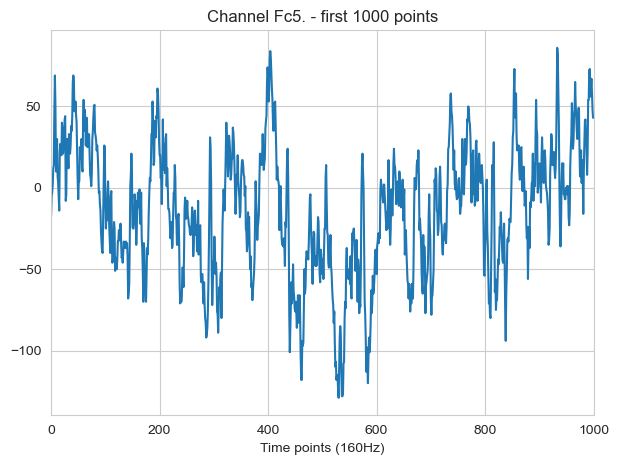

In [6]:
print('Number of time points in recording: ',len(first_recording_df['time']))

fig, axs = plt.subplots(figsize=(7,5))
axs.plot(first_recording_df['Fc5.'][:1000])
axs.set_xlim([0,1000])
axs.set_xlabel('Time points (160Hz)')
axs.set_title('Channel Fc5. - first 1000 points')

In [7]:
mne.events_from_annotations(first_recording)

Used Annotations descriptions: ['T0', 'T1', 'T2']


(array([[    0,     0,     1],
        [  672,     0,     3],
        [ 1328,     0,     1],
        [ 2000,     0,     2],
        [ 2656,     0,     1],
        [ 3328,     0,     3],
        [ 3984,     0,     1],
        [ 4656,     0,     2],
        [ 5312,     0,     1],
        [ 5984,     0,     2],
        [ 6640,     0,     1],
        [ 7312,     0,     3],
        [ 7968,     0,     1],
        [ 8640,     0,     3],
        [ 9296,     0,     1],
        [ 9968,     0,     2],
        [10624,     0,     1],
        [11296,     0,     2],
        [11952,     0,     1],
        [12624,     0,     3],
        [13280,     0,     1],
        [13952,     0,     3],
        [14608,     0,     1],
        [15280,     0,     2],
        [15936,     0,     1],
        [16608,     0,     3],
        [17264,     0,     1],
        [17936,     0,     2],
        [18592,     0,     1],
        [19264,     0,     3]]),
 {'T0': 1, 'T1': 2, 'T2': 3})

## Data processing

Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Using matplotlib as 2D backend.


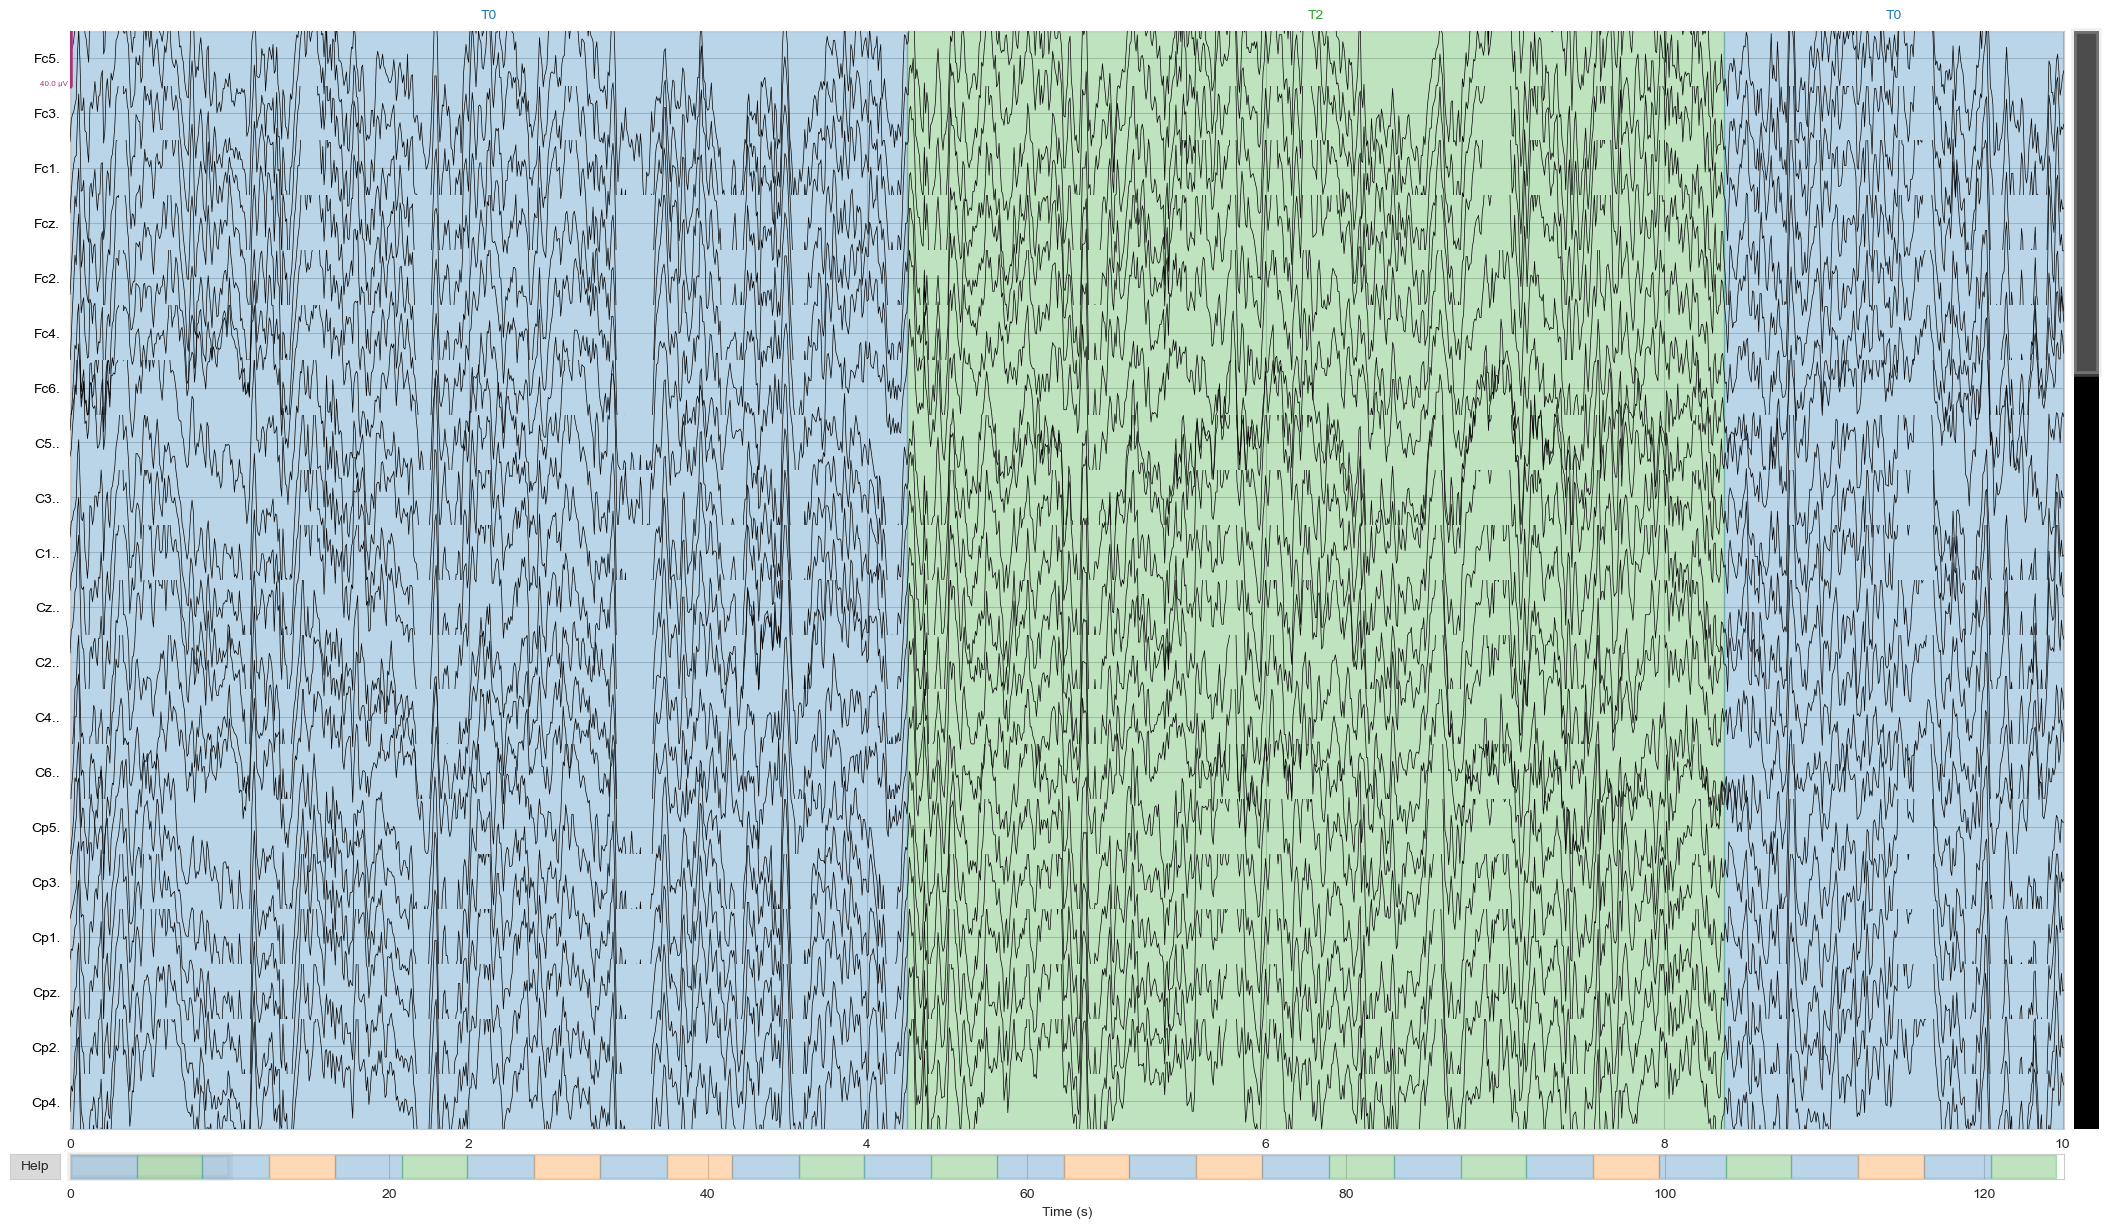

In [8]:
first_recording.load_data()
with mne.viz.use_browser_backend('matplotlib'):
    fig = first_recording.plot(duration=10, proj=False)


In [9]:
first_recording = first_recording.resample(sfreq=(first_recording.info['sfreq']/DOWNSAMPLING_FACTOR))

In [10]:
first_recording_df = first_recording.to_data_frame()
first_recording_df.head()

,time,Fc5.,Fc3.,Fc1.,Fcz.,Fc2.,Fc4.,Fc6.,C5..,C3..,...,P8..,Po7.,Po3.,Poz.,Po4.,Po8.,O1..,Oz..,O2..,Iz..
0,0.0000,-17.013233,-30.008051,-37.035551,-57.019710,-67.001554,-83.990112,-56.958046,-6.001326,-32.000407,...,-11.050661,-15.949278,-14.956112,-5.991956,-10.011564,18.009388,-21.998584,-4.000407,-76.990641,-50.986035
1,0.0125,0.133255,-7.534512,-7.746662,-21.463564,-25.068205,-50.369956,-36.844880,12.707218,-15.920563,...,-4.093382,-0.206467,-2.604309,1.111331,-8.859213,23.166691,-18.117936,-8.655852,-78.709217,-54.245130
2,0.0250,5.314849,-7.935225,-0.302177,6.389128,3.583523,-21.721307,-12.419517,18.496143,-13.491182,...,30.814445,34.932997,28.150779,32.625702,31.677899,70.663658,22.545218,37.026433,-33.300717,1.331311
3,0.0375,48.017953,33.824267,32.706420,25.479796,29.790785,7.465435,10.449169,57.598818,25.603480,...,45.180860,54.059629,49.947786,49.311277,52.577814,84.659093,60.568348,72.293894,2.209063,56.005841
4,0.0500,48.579846,29.817402,20.854055,2.054997,10.342322,-12.920396,7.531572,46.244774,14.197269,...,-23.617571,4.093930,4.252161,-9.761610,-20.466646,11.295870,9.203327,5.999028,-66.761979,-23.601405


In [11]:
print('Shape of first_recording_df: ', first_recording_df.shape)

Shape of first_recording_df:  (10000, 65)


In [12]:
first_recording_df_wtime = first_recording_df.drop(['time'], axis=1)
first_recording_numpy = first_recording_df_wtime.to_numpy()
first_recording_numpy = first_recording_numpy.reshape((np.shape(first_recording_numpy)[1], -1))
print('Shape of input data for model: ',np.shape(first_recording_numpy))

Shape of input data for model:  (64, 10000)


# Model prototype

<img src="/Users/ivojohn/BCI/Models/Motor imaginery fists right:left/EEGNet-based for low-power edge computing/Screen Shot 2022-10-30 at 3.34.03 PM.png">

* Ns - number of input samples in time domain
* Nch - number of EEG channels
* Ncl - number of classes
* Nf - filter size of first temporal filter
* Np - pooling length
</br></br>
* n - number of filters
* p - padding strategy

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using {} device'.format(device))

Using cpu device


In [15]:
EEGNet = EEGNet_lowpower(task_mode=TASK_MODE)
if torch.cuda.device_count() > 1:
    print('Using {} GPUs'.format(torch.cuda.device_count()))
    EEGNet = nn.DataParallel(EEGNet)
else:
    print('Loading the model to one GPU')
print(EEGNet)
X = torch.rand(1,1,64,480, device=device)
output = EEGNet(X)

Loading the model to one GPU
EEGNet_lowpower(
  (temp_conv): TemporalConvolution(
    (conv1): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=same)
    (conv2): Conv2d(8, 8, kernel_size=(64, 1), stride=(1, 1), padding=same)
  )
  (batch_norm_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (depthwise_conv): DepthWiseConvolution(
    (conv1): Conv2d(8, 8, kernel_size=(64, 1), stride=(1, 1), padding=valid, groups=8)
    (conv2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), padding=valid)
  )
  (batch_norm_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu_1): ELU(alpha=1.0)
  (avg_pool_1): AvgPool2d(kernel_size=(1, 8), stride=8, padding=0)
  (separable_conv): Conv2d(16, 16, kernel_size=(16, 1), stride=(1, 1), padding=same)
  (batch_norm_3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu_2): ELU(alpha=1.0)
  (avg_pool_2): AvgPool2d(kernel_size=(1, 8), stride=(1

In [16]:
output

tensor([[0.2289, 0.1803, 0.1448, 0.2058, 0.2402]], grad_fn=<SoftmaxBackward0>)

## Data loader

In [17]:
dataset_path = '/Users/ivojohn/BCI/Models/Motor imaginery fists right:left/Dataset/files'

train_ids, val_ids, test_ids = CreateIDs(dataset_path=dataset_path,
n_samples_per_recording=N_SAMPLES_PER_RECORDING, task_mode=TASK_MODE, split_ratio=(0.7,0.2,0.1)).create()

Found 109 patient's folders
Data will be split with ratio 70.0% train, 20.0% val, 10.0% test
Splitting data into train, val and test set according to recordings, val and test will use ceil int
Checking train IDs


  0%|          | 0/4895 [00:00<?, ?it/s]

Checking validation IDs


  0%|          | 0/1635 [00:00<?, ?it/s]

Checking test IDs


  0%|          | 0/1090 [00:00<?, ?it/s]

Created 4145 train, 1445 validation, and 950 test IDs


Dataset modes:
1. rest_unrest - predicts T0 vs rest (2 classes), uses all runs
2. left_right - predicts T0-T1-T2 (3 classes), uses runs 3,4,7,8,11,12, predicts left (T1) first or right first(T2)
3. upper_lower - predicts T0-T1-T2 (3 classes), uses runs 5,6,9,10,13,14
4. all tasks - predicts 5 classes (rest, left, right, both, feet)

In [18]:
training_dataset = DataSet(list_IDs=train_ids, dataset_path=dataset_path, sample_length=480, task_mode=TASK_MODE)
validation_dataset = DataSet(list_IDs=val_ids, dataset_path=dataset_path, sample_length=480, task_mode=TASK_MODE)
test_dataset = DataSet(list_IDs=test_ids, dataset_path=dataset_path, sample_length=480, task_mode=TASK_MODE)

training_data_loader = DataLoader(training_dataset, batch_size=10,shuffle=True)
validation_data_loader = DataLoader(training_dataset, batch_size=10,shuffle=True)
test_data_loader = DataLoader(training_dataset, batch_size=10,shuffle=True)

for x,y in training_data_loader:
    break
y

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])

# Training

6 minutes per epoch

In [19]:
save_path = '/Users/ivojohn/BCI/Models/Motor imaginery fists right:left/EEGNet-based for low-power edge computing/runs/run0'

torch.cuda.empty_cache()
EEGNet = EEGNet_lowpower(task_mode=TASK_MODE).to(device)

#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(EEGNet.parameters(), lr=0.001)

training_loop = TrainingLoop(
    model=EEGNet,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    training_DataLoader=training_data_loader,
    epochs=2,
    save_path=save_path
)

training_losses, validation_losses, lr_rates = training_loop.run_training()

  0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
out = EEGNet(x)
print(out)
print(y)

tensor([[9.9899e-01, 1.4232e-04, 2.8969e-04, 2.6402e-04, 3.0962e-04],
        [9.9635e-01, 5.5237e-04, 1.0273e-03, 1.1148e-03, 9.5218e-04],
        [9.9905e-01, 1.3835e-04, 3.0369e-04, 2.3872e-04, 2.7223e-04],
        [9.9928e-01, 9.0693e-05, 2.4183e-04, 1.5506e-04, 2.2779e-04],
        [9.9848e-01, 2.4997e-04, 3.6609e-04, 4.3051e-04, 4.7110e-04],
        [9.9564e-01, 8.0719e-04, 1.1041e-03, 9.7952e-04, 1.4657e-03],
        [9.9498e-01, 7.3174e-04, 1.4951e-03, 1.1551e-03, 1.6402e-03],
        [9.9851e-01, 2.2821e-04, 4.0850e-04, 3.7383e-04, 4.7853e-04],
        [9.9609e-01, 5.6771e-04, 9.2986e-04, 1.1133e-03, 1.2950e-03],
        [9.9418e-01, 9.8917e-04, 1.5221e-03, 1.3812e-03, 1.9263e-03]],
       grad_fn=<SoftmaxBackward0>)
tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0.,